# Introduction to the Monte Carlo method

----

Start by defining the [Gibbs (or Boltzmann) distribution](https://en.wikipedia.org/wiki/Boltzmann_distribution):
$$P(\alpha) = e^{-E(\alpha)/kT}$$
this expression, defines the probability of observing a particular configuration of spins, $\alpha$. 
As you can see, the probability of $\alpha$ decays exponentially with increasing energy of $\alpha$, $E(\alpha)$,
where $k$ is the Boltzmann constant, $k = 1.38064852 \times 10^{-23} J/K$
and $T$ is the temperature in Kelvin. 

## What defines the energy of a configuration of spins? 
Given a configuration of spins (e.g., $\uparrow\downarrow\downarrow\uparrow\downarrow$) we can define the energy using what is referred to as an Ising Hamiltonian:
$$ \hat{H}' = \frac{\hat{H}}{k} = -\frac{J}{k}\sum_{<ij>} s_is_j + \frac{\mu}{k}\sum_{i} S_i,$$
where, $s_i=1$ if the $i^{th}$ spin is `up` and $s_i=-1$ if it is `down`, and the brackets $<ij>$ indicate a sum over spins that are connected,
and $J$ is a constant that determines the energy scale. 
The energy here has been divided by the Boltzmann constant to yield units of temperature. 
Let's consider the following case, which has the sites connected in a single 1D line:
$$\alpha = \uparrow-\downarrow-\downarrow-\uparrow-\downarrow.$$ 
What is the energy of such a configuration?
$$ E(\alpha)' = \frac{-J}{k}(-1 + 1 - 1 - 1) + \frac{\mu}{k}(1 + -1 + -1 + 1 + -1) = \frac{E(\alpha)}{k} = 2\frac{J}{k} - \frac{\mu}{k}$$

## P1: Write a class that defines a spin configuration

In [141]:
class SpinConfig:
    def __init__(self, spin_str, closed=False):
        self.__spin_str = [-1 if x == '-' or x == '0' else 1 for x in spin_str]
        self.__index = 0
        self.__closed = closed
    def __repr__(self):
        return ''.join(['↓' if x == -1 else '↑' for x in self.__spin_str])
    def __getitem__(self, item):
         return self.__spin_str[item]
    def __len__(self):
        return len(self.__spin_str)
    def closed(self):
        return self.__closed
    def magnetization(self):
        return sum(self.__spin_str)

## P2: Write a class that defines the 1D hamiltonian, containing a function that computes the energy of a configuration

In [142]:
class Hamiltonian:
    def __init__(self, k, J, mu):
        self.k = k
        self.J = J
        self.mu = mu
    def energy(self, spin_config):
        if spin_config.closed():
            return (-self.J * sum(spin_config[i - 1] * spin_config[i] for i in range(len(spin_config))) + self.mu * sum(spin_config))/self.k
        return (-self.J * sum(spin_config[i] * spin_config[i + 1] for i in range(len(spin_config) - 1)) + self.mu * sum(spin_config))/self.k

## Properties
For any fixed state, $\alpha$, the `magnetization` ($M$) is proportional to the _excess_ number of spins pointing up or down while the energy is given by the
Hamiltonian:
$$M(\alpha) = N_{\text{up}}(\alpha) - N_{\text{down}}(\alpha).$$
As a dynamical, fluctuating system, each time you measure the magnetization, the system might be in a different state ($\alpha$) and so you'll get a different number!
However, we already know what the probability of measuring any particular $\alpha$ is, so in order to compute the average magnetization, $\left<M\right>$, we just need to multiply the magnetization of each possible configuration times the probability of it being measured, and then add them all up!
$$ \left<M\right> = \sum_\alpha M(\alpha)P(\alpha).$$
In fact, any average value can be obtained by adding up the value of an individual configuration multiplied by it's probability:
$$ \left<E\right> = \sum_\alpha E(\alpha)P(\alpha).$$

This means that to obtain any average value (also known as an `expectation value`) computationally, we must compute the both the value and probability of all possible configurations. This becomes extremely expensive as the number of spins ($N$) increases. 

## P3: Write a function that computes the magnetization of a spin configuration

In [143]:
magnetization = lambda spin_config : sum(spin_config)

## Q2: How many configurations are possible for:

(a) N=10?

In [144]:
2**10

1024

(b) N=100?

In [145]:
2**100

1267650600228229401496703205376

(c) N=1000?

In [146]:
2**1000

10715086071862673209484250490600018105614048117055336074437503883703510511249361224931983788156958581275946729175531468251871452856923140435984577574698574803934567774824230985421074605062371141877954182153046474983581941267398767559165543946077062914571196477686542167660429831652624386837205668069376

## Q3: What is the energy for (++-+---+--+)?

In [147]:
H = Hamiltonian(k=1, J=2, mu=1.1)
H.energy(SpinConfig("++-+---+--+"))

2.9

## Plot

In [148]:
import numpy as np

def probability(spin_config, temp, hamiltonian):
    return np.exp((-1/temp) * hamiltonian.energy(spin_config))

In [149]:
def avg_energy(n_site, isClosed, temp, hamiltonian, power=1):
    num = denum = 0
    for x in range(2**n_site):
        s = SpinConfig(bin(x)[2:].zfill(n_site), isClosed)
        p = probability(s, temp, hamiltonian)
        num += (hamiltonian.energy(s) ** power) * p
        denum += p
    return num/denum

def avg_mag(n_site, isClosed, temp, hamiltonian, power=1):
    num = denum = 0
    for x in range(2**n_site):
        s = SpinConfig(bin(x)[2:].zfill(n_site), isClosed)
        p = probability(s, temp, hamiltonian)
        num += (s.magnetization() ** power) * p
        denum += p
    return num/denum

In [150]:
def heat_capacity(n_site, isClosed, temp, hamiltonian):
    return (avg_energy(8, isClosed, temp, hamiltonian, power=2) - (avg_energy(8, isClosed, temp, hamiltonian) ** 2)) / (temp ** 2)

def magnetic_susceptibility(n_site, isClosed, temp, hamiltonian):
    return (avg_mag(8, isClosed, temp, hamiltonian, power=2) - (avg_mag(8, isClosed, temp, hamiltonian) ** 2)) / temp

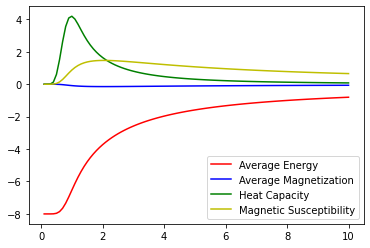

In [155]:
import matplotlib.pyplot as plt

H = Hamiltonian(k=1, J=-1, mu=.1)
T = np.linspace(.1,10,100)
isClosed = True

AE = avg_energy(8, isClosed, T, H)
AM = avg_mag(8, isClosed, T, H)

HC = heat_capacity(8, isClosed, T, H)
MS = magnetic_susceptibility(8, isClosed, T, H)

fig = plt.figure()

plt.plot(T,AE,'r', label='Average Energy')
plt.plot(T,AM,'b', label='Average Magnetization')
plt.plot(T,HC,'g', label='Heat Capacity')
plt.plot(T,MS,'y', label='Magnetic Susceptibility')

plt.legend()
plt.show()

## Testing

In [157]:
H = Hamiltonian(k=1, J=1, mu=.1)

def test_SpinConfig():
    conf = SpinConfig('----++++', True)
    conf2 = SpinConfig('00001111')
    assert(list(conf) == list(conf2))
    assert(list(conf) == [-1, -1, -1, -1, 1, 1, 1, 1])
    assert(str(conf) == "↓↓↓↓↑↑↑↑")
    assert(conf.closed() is True)
    assert(conf2.closed() is False)
    assert(len(conf) == 8)
    assert(conf.magnetization() == 0)
    assert(H.energy(conf) == -4.0)
    assert(conf.magnetization() == 0)

def test_avg_values():
    H = Hamiltonian(k=-1, J=-2, mu=1.1)
    np.testing.assert_almost_equal(avg_energy(2, True, 1, H), -6.1458897)
    np.testing.assert_almost_equal(avg_mag(2, True, 1, H), 1.9513429)
    
test_SpinConfig()
test_avg_values()